# Parameterization

*Keith Y. Patarroyo*  
*University of Glasgow & Chemify & Wolfram Research*

*keith.patarroyo@gmail.com*

*May 24, 2022*
___

![alt text](data/back.png)

## Table of Contents
0. [Requirements](#requirements)
1. [Mesh Representation](#mesh) 
    - 1.1 [Sample Meshes](#sample)
2. [Fixed Boundary Parameterization](#fixed)
    - 2.1 [Tutte - Uniform Weights Parameterization](#tutte)
    - 2.2 [Mean Value Parameterization](#mean)
    - 2.3 [Harmonic Parameterization](#harmonic)
3. [Free Boundary Parameterization](#free)
    - 3.1 [As Rigid As Possible(ARAP) - Parameterization](#arap)
    - 3.2 [Least Squares Conformal Map(LSCM) - Parameterization](#lscm)
4. [Atlas Parameterization](#atlas)
    - 4.1 [Artistic Parameterization](#artistic)
    - 4.2 [Extra Topics](#extra)
5. [Appendix: Harmonic Parameterization Implementation](#appendix)
6. [References](#references)
___

#  <a id='requirements'></a>0. Requirements

Only two libraries are needed for this notebook:

    - Libigl 
    - Meshplot
Libigl can be downloaded from Conda forge:

All of libigl functionality depends only on ```numpy``` and ```scipy```. For the visualization in this tutorial we use meshplot which can be easily installed from Conda:

The tutorials and documentation for both libraries can be found [here](https://libigl.github.io/libigl-python-bindings/tut-chapter0/) and [here](https://skoch9.github.io/meshplot/tutorial/).

In [1]:
import igl
import scipy as sp
import numpy as np
from meshplot import plot, subplot, interact, utils

import os
import matplotlib.pyplot as plt
from IPython.display import Image, display
import PIL as PIL
from PIL import ImageOps
root_folder = os.getcwd()

#  <a id='mesh'></a> 1. Mesh Representation

Libigl uses ```numpy``` to encode vectors and matrices and ```scipy``` for sparse matrices.

A triangular mesh is encoded as a pair of matrices:

```
v: np.array
f: np.array
```
```v``` is a #N by 3 matrix which stores the coordinates of the vertices. Each row stores the coordinate of a vertex, with its x, y and z coordinates in the first, second and third column, respectively. The matrix ```f``` stores the triangle connectivity: each line of ```f``` denotes a triangle whose 3 vertices are represented as indices pointing to rows of ```f```.

![](https://libigl.github.io/libigl-python-bindings/images/VF.png)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.0, 0.5,…

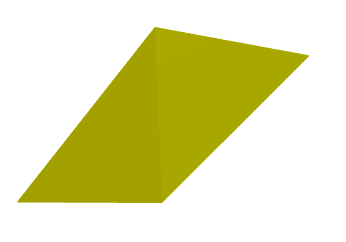

In [2]:
V = np.array([
    [0., 0, 0],
    [1, 0, 0],
    [1, 1, 1],
    [2, 1, 0]
])
F = np.array([
    [0, 1, 2],
    [1, 3, 2]
])
plot(V, F,shading={"width": 300, "height": 300})
Image(os.path.join(root_folder, "data", "mesh-1.png")) # This is what it supposed to look like

##  <a id='sample'></a> 1.1 Sample Meshes

We will work with two meshes, one with open boundary(camel) and the second with no boundary(cow). Download the Camel mesh from this [repository](https://github.com/libigl/libigl-tutorial-data).

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.9967555…

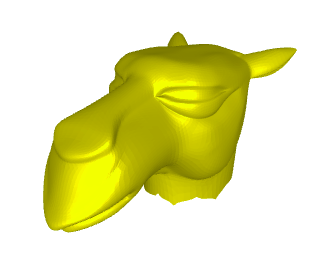

In [3]:
v_camel, f_camel  = igl.read_triangle_mesh(os.path.join(root_folder, "data", "camelhead.off"))
plot(v_camel,f_camel,shading={"width": 300, "height": 300})
Image(os.path.join(root_folder, "data", "mesh-2.png")) # This is what it supposed to look like

Download the Spot(cow) from this [repository](https://www.cs.cmu.edu/~kmcrane/Projects/ModelRepository/)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.10…

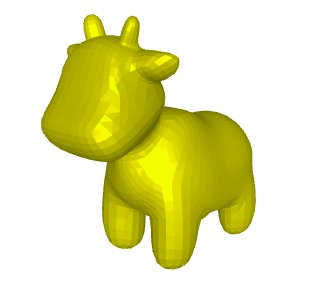

In [4]:
v_cow, f_cow  = igl.read_triangle_mesh(os.path.join(root_folder, "data", "spot_triangulated.obj"))
plot(v_cow,f_cow,shading={"width": 300, "height": 300})
Image(os.path.join(root_folder, "data", "mesh-3.png")) # This is what it supposed to look like

#  <a id='fixed'></a> 2. Fixed Boundary Parameterization

We will work with the camel mesh for the fixed boundary case, and we will map its boundary to a circle

In [5]:
## Find the open boundary
bnd = igl.boundary_loop(f_camel)

## Map the boundary to a circle, preserving edge proportions
bnd_uv = igl.map_vertices_to_circle(v_camel, bnd)

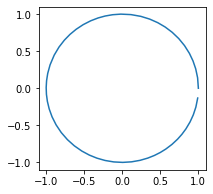

In [6]:
plt.rcParams["figure.figsize"] = (3,3)
plt.plot(bnd_uv[:,0],bnd_uv[:,1])
plt.show()

For each of the fixed boundary parameterization we have to solve the following linear system:

$$A U=\bar{U},$$
where,
$$A=\left\{\begin{array}{c}
1, i=j \\
-\lambda_{i j}, j \in N_{i} \\
0, \text { else }
\end{array}\right. \qquad \lambda_{i j}=D_{i j} / \sum_{k \in N_{i}} D_{i k},$$
and,
$$u_{i}-\underbrace{\sum_{j \in N_{i}, j \leq n} \lambda_{i j} u_{j}}_{\text{unknown parameter points 
}}=\underbrace{\sum_{j \in N_{i}, j>n} \lambda_{i j} u_{j}}_{\text{fixed}}=\bar{u}_{i}.$$
Solve separately for $u$ and $v$.  

$$A=\begin{cases}1 & \text{if }i=j, \\
-\lambda_{i j} & \text{if } j \in N_{i},\\
0 & \text{else }. \\
\end{cases}, \qquad \lambda_{i j}=D_{i j} / \sum_{k \in N_{i}} D_{i k},$$

##  <a id='tutte'></a> 2.1 Tutte - Uniform Weights Parameterization

We will implement the uniform weights parameterization from scratch, in this case the weights are,

$$D_{ij}=1 \qquad \lambda_{ij}=\frac{1}{N_i},$$

where $N_i$ is the number of neighbors. So that is the fist step in our algorithm:

In [7]:
neighbors = [[] for i in enumerate(v_camel)]
for i,face in enumerate(f_camel):
    neighbors[face[0]].append(i)
    neighbors[face[1]].append(i)
    neighbors[face[2]].append(i)

Now we will build the linear system $A$ with the row, column, value data structure:

In [8]:
rows = []
columns = []
data = []
for i,j in enumerate(v_camel):
    real_neighbors = list(set(f_camel[neighbors[i]].flatten())-{i})
    for neighbor in real_neighbors:
        rows.append(i)
        columns.append(neighbor)
        data.append(-1./len(real_neighbors))
    rows.append(i)
    columns.append(i)
    data.append(1)
A = sp.sparse.coo_matrix((data, (rows, columns)))

We start to assemble the right side with the values of the boundary:

In [9]:
b_pre = np.array([bnd_uv[np.where(bnd==i)[0][0]] if np.isin(i,bnd) else np.array([0,0]) for i,j in enumerate(v_camel)])

Now we multiply the boundary value $u_{j}$ by the weights $\lambda_{ij}$, as a matrix multiplication

In [10]:
b_0 = A.dot(b_pre[:,0])*-1
b_1 = A.dot(b_pre[:,1])*-1

We delete the columns of boundary values of both $A$ and $b=\bar{U}$ since they are fixed and we sont found a solution for them:

In [11]:
b_0_final = np.delete(b_0,bnd,0)
b_1_final = np.delete(b_1,bnd,0)

In [12]:
A_final = sp.sparse.csr_matrix(np.delete(A.toarray(),bnd, axis=0))
A_final = sp.sparse.csr_matrix(np.delete(A_final.toarray(),bnd, axis=1))

We solve the linear systems $Au=b$ and $Av=b$,

In [13]:
u_pre = sp.sparse.linalg.spsolve(A_final, b_0_final)
v_pre = sp.sparse.linalg.spsolve(A_final, b_1_final)

We append the boundary values of $u$ and $v$ with the deleted boundary.

In [14]:
counter1 = 0
u_final = []
v_final = []
for i,j in enumerate(v_camel):
    if i in bnd:
        u_final.append(bnd_uv[np.where(bnd==i)[0][0]][0])
        v_final.append(bnd_uv[np.where(bnd==i)[0][0]][1])
    else:
        u_final.append(u_pre[counter1])
        v_final.append(v_pre[counter1])
        counter1 = counter1 + 1

In [15]:
uv = np.column_stack([u_final, v_final])
v_p = np.hstack([uv, np.zeros((uv.shape[0],1))])

Now we plot the $uv$ space, triangulation alone, with a checkers parametrization, and the mesh with the texture coming from the parameterization:

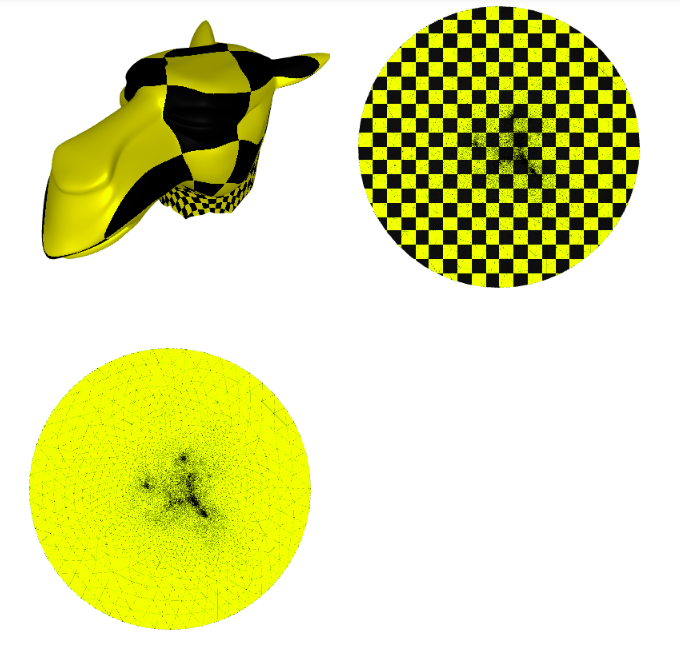

In [16]:
p = subplot(v_camel, f_camel, uv=uv, shading={"wireframe": False, "flat": False}, s=[1, 2, 0])
subplot(uv, f_camel, uv=uv, shading={"wireframe": True, "flat": False}, s=[1, 2, 1],data=p)
subplot(uv, f_camel, uv=uv, shading={"wireframe": True, "flat": False}, s=[1, 2, 1],texture_data=utils.gen_checkers(1,1,1,1))
Image(os.path.join(root_folder, "data", "mesh-4.png")) # This is what it supposed to look like

##  <a id='mean'></a> 2.2 Mean Value Parametrization

We will implement the mean weights parameterization from scratch as well, in this case the weights are,

$$D_{ij}=\frac{\tan\frac{\alpha_{ij}}{2}+ \tan\frac{\beta_{ij}}{2}}{r_{ij}} \qquad \lambda_{i j}=D_{i j} / \sum_{k \in N_{i}} D_{i k},$$

where $N_i$ is the number of neighbors. For the geometric meaning of $\alpha_{ij},\beta_{ij},r_{ij}$, please see the slides.  

Now, we create a function to assemble matrix $D=l$ with one in the diagonal:

In [17]:
def mean_value_diy(v,f):
    n = np.shape(v)[0]
    L = sp.sparse.identity(n).tolil()
    for face in f:
        for e in range(3):
            i,j,k = (face[e],face[(e+1)%3],face[(e+2)%3])
            p1,p2,p3 = (v[i],v[j],v[k])
            alpha = np.arctan2(np.linalg.norm(np.cross(p2-p3,p1-p3)),np.dot(p2-p3,p1-p3))
            beta = np.arctan2(np.linalg.norm(np.cross(p3-p2,p1-p2)),np.dot(p3-p2,p1-p2))
            gamma = np.arctan2(np.linalg.norm(np.cross(p2-p1,p3-p1)),np.dot(p2-p1,p3-p1))
            L[i,j] = L[i,j] - np.tan(gamma*0.5)/np.linalg.norm(p2-p1)
            L[j,i] = L[j,i] - np.tan(beta*0.5)/np.linalg.norm(p2-p1)
    return(L)
l = mean_value_diy(v_camel,f_camel)

Now we will build the linear system $A$ with the row, column, value data structure:

In [18]:
columns = l.tocoo().col
rows = l.tocoo().row
data = l.tocoo().data
row_sum = np.zeros([np.shape(v_camel)[0]])
for index, row in enumerate(rows):
    if columns[index] == rows[index]:
        row_sum[row] = row_sum[row]
    else:
        row_sum[row] = row_sum[row] + data[index]
new_data = np.zeros([np.shape(data)[0]])
for i,j in enumerate(data):
    if columns[i] == rows[i]:
        new_data[i] = 1.
    else:
        new_data[i] = -1*j/row_sum[rows[i]]
A = sp.sparse.coo_matrix((new_data, (rows, columns)))

Now we proceed the same way as we did before with the uniform weight, to generate the parameterization.

In [19]:
b_pre = np.array([bnd_uv[np.where(bnd==i)[0][0]] if np.isin(i,bnd) else np.array([0,0]) for i,j in enumerate(v_camel)])
b_0 = A.dot(b_pre[:,0])*-1
b_1 = A.dot(b_pre[:,1])*-1
b_0_final = np.delete(b_0,bnd,0)
b_1_final = np.delete(b_1,bnd,0)
A_final = sp.sparse.csr_matrix(np.delete(A.toarray(),bnd, axis=0))
A_final = sp.sparse.csr_matrix(np.delete(A_final.toarray(),bnd, axis=1))
u_pre = sp.sparse.linalg.spsolve(A_final, b_0_final)
v_pre = sp.sparse.linalg.spsolve(A_final, b_1_final)
counter1 = 0
u_final = []
v_final = []
for i,j in enumerate(v_camel):
    if i in bnd:
        u_final.append(bnd_uv[np.where(bnd==i)[0][0]][0])
        v_final.append(bnd_uv[np.where(bnd==i)[0][0]][1])
    else:
        u_final.append(u_pre[counter1])
        v_final.append(v_pre[counter1])
        counter1 = counter1 + 1
uv = np.column_stack([u_final, v_final])
v_p = np.hstack([uv, np.zeros((uv.shape[0],1))])

Now we plot the $uv$ space, triangulation alone, with a checkers parametrization, and the mesh with the texture coming from the parameterization:

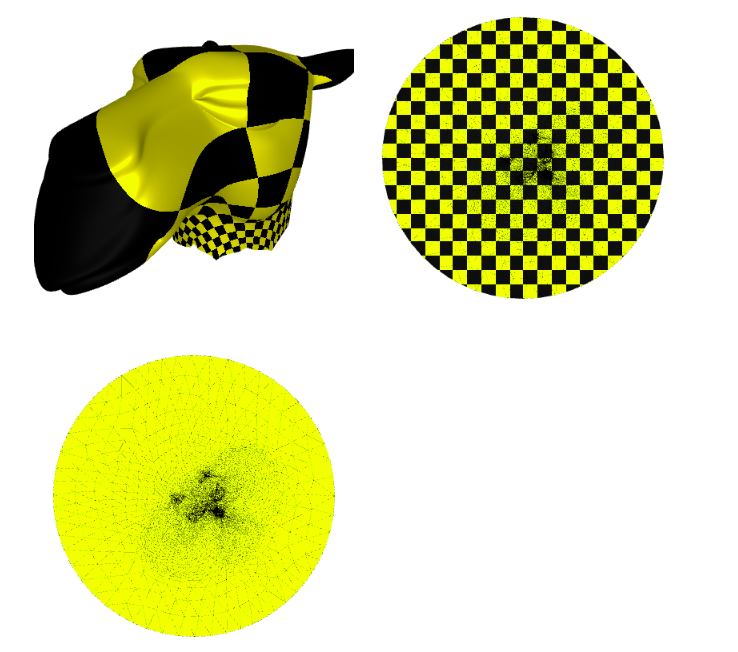

In [20]:
p = subplot(v_camel, f_camel, uv=uv, shading={"wireframe": False, "flat": False}, s=[1, 2, 0])
subplot(uv, f_camel, uv=uv, shading={"wireframe": True, "flat": False}, s=[1, 2, 1],data=p)
subplot(uv, f_camel, uv=uv, shading={"wireframe": True, "flat": False}, s=[1, 2, 1],texture_data=utils.gen_checkers(1,1,1,1))
Image(os.path.join(root_folder, "data", "mesh-5.png")) # This is what it supposed to look like

##  <a id='harmonic'></a> 2.3 Harmonic Parameterization

For the harmonic case we wil use the libigl ```harmonic_weights()``` function, in this case the weights are,

$$D_{ij}=\cot(\gamma_{ij}) + \cot(\gamma_{ji}) \qquad \lambda_{i j}=D_{i j} / \sum_{k \in N_{i}} D_{i k},$$

where $N_i$ is the number of neighbors. For the geometric meaning of $\gamma_{ij}$, please see the slides.  

*For a full implementation of this algorithm see the [Appendix](#appendix).

In [21]:
## Harmonic parametrization for the internal vertices
uv = igl.harmonic_weights(v_camel, f_camel, bnd, bnd_uv, 1)
v_p = np.hstack([uv, np.zeros((uv.shape[0],1))])

Now we plot the $uv$ space, triangulation alone, with a checkers parametrization, and the mesh with the texture coming from the parameterization:

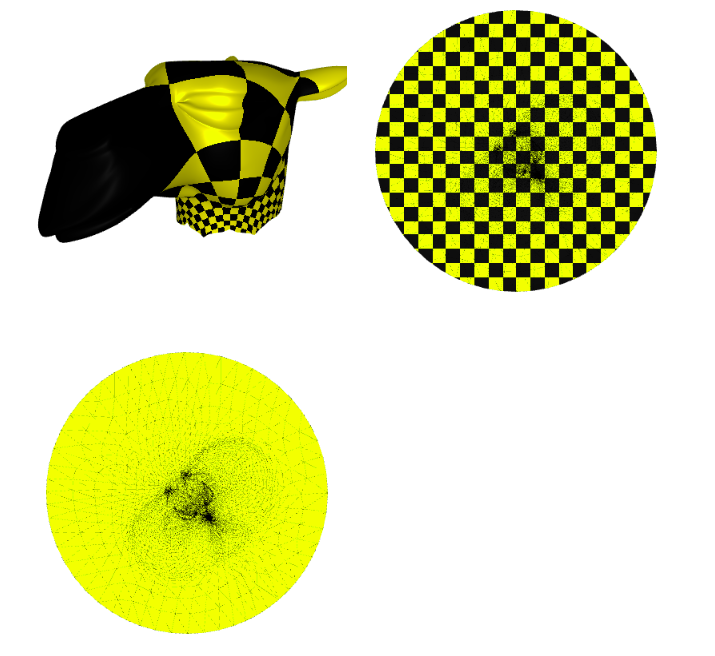

In [22]:
p = subplot(v_camel, f_camel, uv=uv, shading={"wireframe": False, "flat": False}, s=[1, 2, 0])
subplot(uv, f_camel, uv=uv, shading={"wireframe": True, "flat": False}, s=[1, 2, 1],data=p)
subplot(uv, f_camel, uv=uv, shading={"wireframe": True, "flat": False}, s=[1, 2, 1],texture_data=utils.gen_checkers(1,1,1,1))
Image(os.path.join(root_folder, "data", "mesh-6.png")) # This is what it supposed to look like

#  <a id='free'></a> 3 Free Boundary Parameterization


Fundamentally the algorithms for free boundary parameterization follow the recepie:

    - Choose an energy(conformal energy, angle distortion)
    - Start with an initial bijective parameterization
        - E.g. Tutte - Uniform Weights
    - Use nonlinear optimization tools to minimize
        - Gradient descent
        - Quasi-Newton methods
        - …

##  <a id='arap'></a>3.1 As Rigid As Possible(ARAP) -  Parameterization

As-rigid-as-possible is a powerful single-patch, non-linear algorithm to compute a parametrization that strives to preserve distances (and thus angles). The idea is that each triangle is mapped to the plane trying to preserve its original shape, up to a rigid rotation.

We use the libigl ```harmonic_weights()``` function to initialize the Parameterization, then we initialize the ```igl.ARAP()``` solver, then we solve the specific initial condition with ```arap.solve()```:

In [23]:
## Harmonic parameterization for the internal vertices
uv = igl.harmonic_weights(v_camel, f_camel, bnd, bnd_uv, 1)

arap = igl.ARAP(v_camel, f_camel, 2, np.zeros(0))
uva = arap.solve(np.zeros((0, 0)), uv)

We solved the non-linear problem by minimizing an approximate quadratic energy with the solver from libigl.

Now we plot the $uv$ space, triangulation alone, with a checkers parametrization, and the mesh with the texture coming from the parameterization:

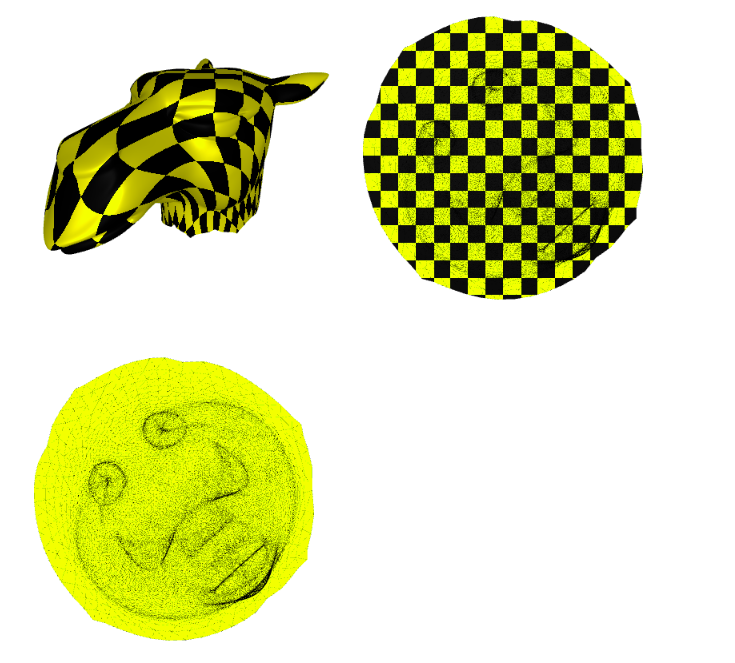

In [24]:
p = subplot(v_camel, f_camel, uv=uva, shading={"wireframe": False, "flat": False}, s=[1, 2, 0])
subplot(uva, f_camel, uv=uva, shading={"wireframe": True, "flat": False}, s=[1, 2, 1],data=p)
subplot(uva, f_camel, uv=uva, shading={"wireframe": True, "flat": False}, s=[1, 2, 1],texture_data=utils.gen_checkers(1,1,1,1))
Image(os.path.join(root_folder, "data", "mesh-7.png")) # This is what it supposed to look like

##  <a id='lscm'></a> 3.2 Least Squares Conformal Map(LSCM) - Parameterization


Least squares conformal maps parametrization minimizes the conformal (angular) distortion of the parametrization. Differently from harmonic parametrization, it does not need to have a fixed boundary. In this case we would use a different mesh than before, a mesh with no boundary. 

In [25]:
v_cow_sur, f_cow_sur  = igl.read_triangle_mesh(os.path.join(root_folder, "data", "spot_surgery.obj"))

Even though the mesh has no boundary, we are looking for a parameterization that is bijective, so we make a small surgery to the mesh, to obtain a global parameterization. 

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.10…

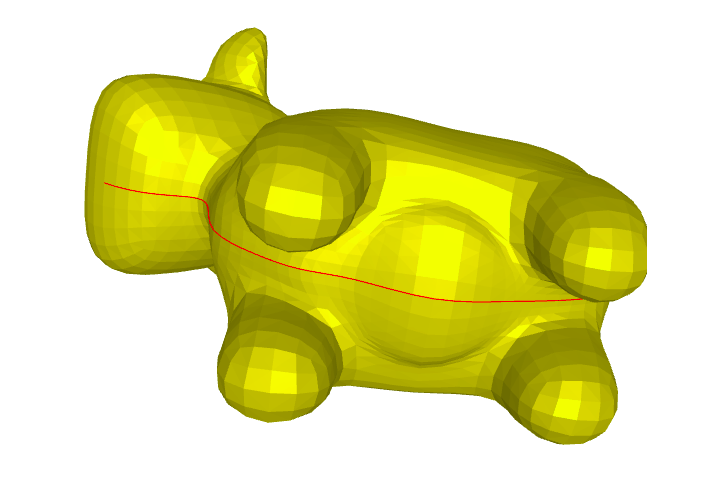

In [26]:
surgery = np.genfromtxt(os.path.join(root_folder, "data", "surgery.csv"), delimiter=',')
faces_pre = []
for i,value in enumerate(surgery):
    faces_pre.append([i,i+1])
faces = np.array(faces_pre[0:-1], dtype=np.int)
p = plot(v_cow_sur,f_cow_sur)
p.add_edges(surgery, faces, shading={"line_color": "red"});
p.add_points(surgery, shading={"point_color": "green"})
Image(os.path.join(root_folder, "data", "mesh-10.png")) # This is what it supposed to look like

We generate a boundary in the surgery line, and duplicate the vertices along this line. Therefore the triangles left to the line have different vertices than the triangles right to the line. 

Note that although we created a boundary, in this case we do not need to fix the boundary. To remove the null space of the energy and make the minimum unique, it is sufficient to fix two arbitrary vertices to two arbitrary positions. 

In [27]:
# Fix two points on the boundary
b = np.array([2, 1])

bnd = igl.boundary_loop(f_cow_sur)
b[0] = bnd[0]
b[1] = bnd[int(bnd.size / 2)]

bc = np.array([[0.0, 0.0], [1.0, 0.0]])

# LSCM parametrization
_, uv = igl.lscm(v_cow_sur, f_cow_sur, b, bc)

We solved the non-linear problem by minimizing an approximate quadratic energy with the solver from libigl inside the function ```lscm()```.

Now we plot the $uv$ space, triangulation alone, with a checkers parametrization, and the mesh with the texture coming from the parameterization:

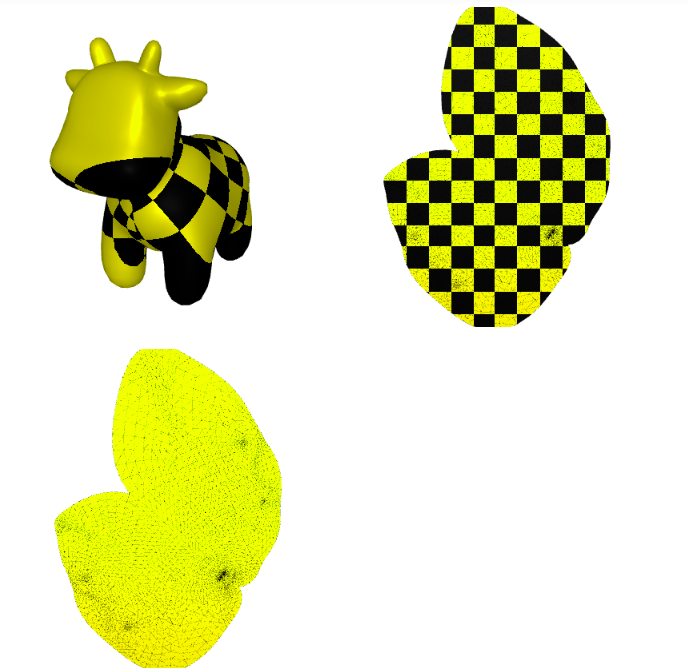

In [28]:
p = subplot(v_cow_sur, f_cow_sur, uv=uv, shading={"wireframe": False, "flat": False}, s=[1, 2, 0])
subplot(uv, f_cow_sur, uv=uv, shading={"wireframe": True, "flat": False}, s=[1, 2, 1],data=p)
subplot(uv, f_cow_sur, uv=uv, shading={"wireframe": True, "flat": False}, s=[1, 2, 1],texture_data=utils.gen_checkers(1,1,1,1))
Image(os.path.join(root_folder, "data", "mesh-8.png")) # This is what it supposed to look like

# 4.  <a id='atlas'></a> Atlas Parameterization

A different approach consists in separate the mesh in several parts. For this we initially cut the mesh in multiple patches that can be separately parametrized. The generated maps are discontinuous on the cuts (often referred as seams).

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.10…

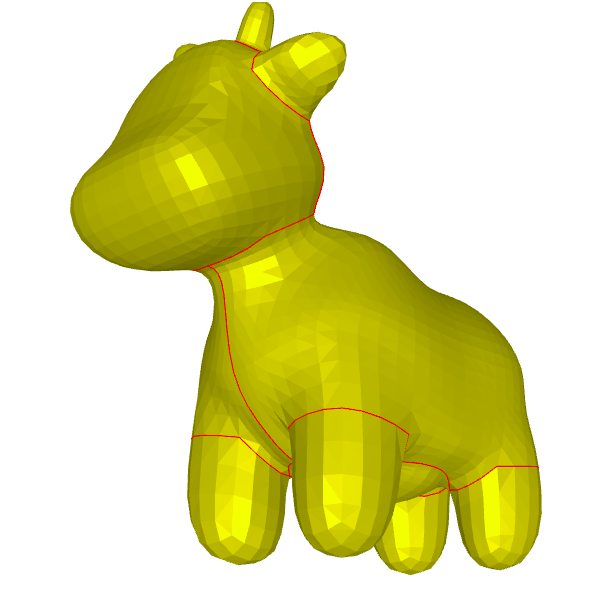

In [29]:
vmod_spot = np.genfromtxt(os.path.join(root_folder, "data", "vmod_spot.csv"), delimiter=',')
fvp_spot = np.genfromtxt(os.path.join(root_folder, "data", "fvp_spot.csv"), delimiter=',')
uv = np.genfromtxt(os.path.join(root_folder, "data", "uv_spot.csv"), delimiter=',')
p = plot(vmod_spot,fvp_spot)
for i in range(13):
    boundary = np.genfromtxt(os.path.join(root_folder, "data", 'bnd_{}.csv'.format(i)), delimiter=',')
    faces_pre = []
    for i,value in enumerate(boundary):
        faces_pre.append([i,i+1])
    faces_pre = faces_pre[0:-1]
    faces_pre.append([len(faces_pre),0])
    faces = np.array(faces_pre, dtype=np.int)
    p.add_edges(vmod_spot[boundary.astype(int)], faces, shading={"line_color": "red"});
Image(os.path.join(root_folder, "data", "mesh-11.png")) # This is what it supposed to look like

## 4.1  <a id='artistic'></a>Artistic Parameterization

From these cuts, we can parametrize each of these sections and texture each of them using a design program. 

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4684064…

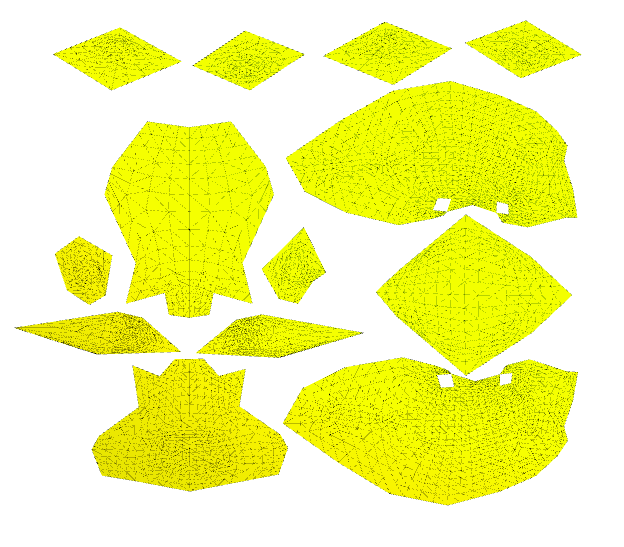

In [30]:
plot(uv, fvp_spot, uv=uv, shading={"wireframe": True, "flat": False},texture_data=utils.gen_checkers(1,1,1,1))
Image(os.path.join(root_folder, "data", "mesh-12.png")) # This is what it supposed to look like

We can paint these textures with the style of a cow. We use the texture from [Keenan Crane repository](https://www.cs.cmu.edu/~kmcrane/Projects/ModelRepository/), slightly modified from 1024x1024 to 1080x1080 to mathc the style of the meshplot texturing algorithm.

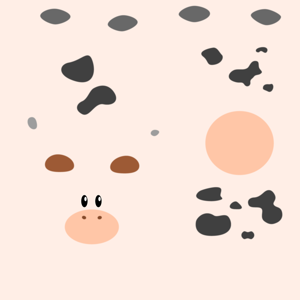

In [31]:
im = PIL.Image.open(os.path.join(root_folder, "data", "spot_texture_mod.png"))
im_flip = ImageOps.flip(im)
pix = np.array(im_flip)/255.
im.resize((300, 300))

We use the $uv$ mapping from Keenan Crane design as well to map the texture to the surface cuts:

/home/mrkeithypatarroyo/anaconda3/envs/combined/lib/python3.6/site-packages/pythreejs/traits.py:203: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '


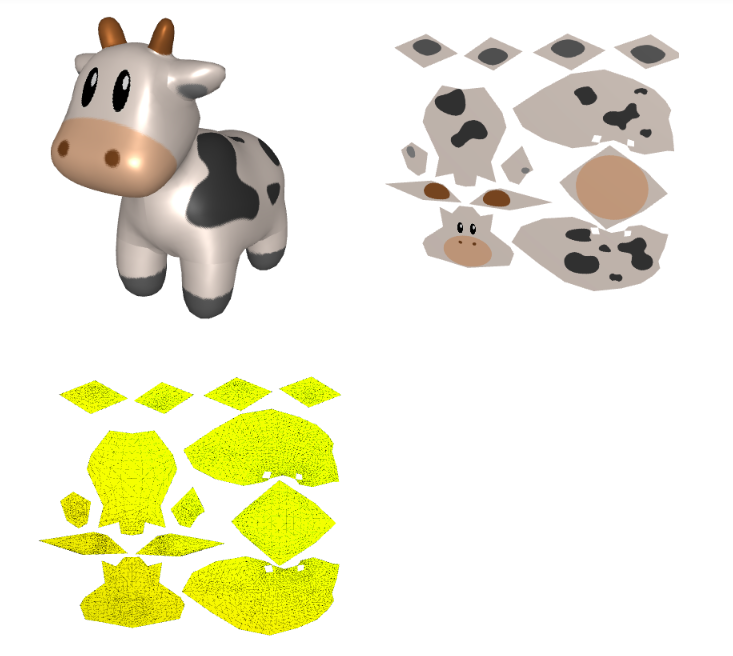

In [32]:
p = subplot(vmod_spot, fvp_spot, uv=uv, shading={"wireframe": False, "flat": False}, s=[1, 2, 0],texture_data=pix[:,:,0:3])
subplot(uv, fvp_spot, uv=uv, shading={"wireframe": False, "flat": False}, s=[1, 2, 1],texture_data=pix[:,:,0:3],data=p)
subplot(uv, fvp_spot, uv=uv, shading={"wireframe": True, "flat": False}, s=[1, 2, 0],texture_data=utils.gen_checkers(1,1,1,1))
Image(os.path.join(root_folder, "data", "mesh-9.png")) # This is what it supposed to look like

## <a id='extra'></a> 4.2 Extra Topics

Other interesting topics related to parameterization are:
- **Global seamless parametrization:** These are global parametrization algorithm that hides the seams, making the parametrization “continuous”, under specific assumptions. For this parameterization it is interesing to analyze vector fields on the surface of meshes. An example of this method is the Poisson Parametrization. See [Global, Seamless Integer-grid Parametrization](https://libigl.github.io/tutorial/#global-seamless-integer-grid-parametrization).
- **Editing of the Resulting Flattened Shape:** Novel algorithms not only allow for a desired parameterization, but users can direct control over the shape of the flattened domain—rather than being stuck with whatever the software provides. See [Boundary First Flattening](https://geometrycollective.github.io/boundary-first-flattening/).

# 5. <a id='appendix'></a>Appendix: Harmonic Parameterization Implementation 

We will implement the mean weights parameterization from scratch as well, in this case the weights are,

$$D_{ij}=\cot(\gamma_{ij}) + \cot(\gamma_{ji}) \qquad \lambda_{i j}=D_{i j} / \sum_{k \in N_{i}} D_{i k},$$

where $N_i$ is the number of neighbors. For the geometric meaning of $\gamma_{ij}$, please see the slides.

Now, we create a function to assemble matrix $D=l$ with one in the diagonal:

In [33]:
def cotmatrix_diy(v,f):
    n = np.shape(v)[0]
    L = sp.sparse.identity(n).tolil()
    for face in f:
        for e in range(3):
            i,j,k = (face[e],face[(e+1)%3],face[(e+2)%3])
            p1,p2,p3 = (v[i],v[j],v[k])
            alpha = np.arctan2(np.linalg.norm(np.cross(p2-p3,p1-p3)),np.dot(p2-p3,p1-p3))
            beta = np.arctan2(np.linalg.norm(np.cross(p3-p2,p1-p2)),np.dot(p3-p2,p1-p2))
            gamma = np.arctan2(np.linalg.norm(np.cross(p2-p1,p3-p1)),np.dot(p2-p1,p3-p1))
            L[i,i] = L[i,i] + 0.5/np.tan(beta)
            L[j,j] = L[j,j] + 0.5/np.tan(gamma)
            L[i,j] = L[i,j] - 0.5/np.tan(alpha)
            L[j,i] = L[j,i] - 0.5/np.tan(alpha)
    L = L - sp.sparse.identity(n).tolil()
    return(L)

There is a function in the library that assembles the negative of this matrix in the libigl library, ```igl.cotmatrix()```, next we compare them using the frobenius norm:

In [34]:
L = igl.cotmatrix(v_camel, f_camel)
l = cotmatrix_diy(v_camel,f_camel)
sp.sparse.linalg.norm(L-(l*-1))

3.94601343956224e-11

Now we will build the linear system $A$ with the row, column, value data structure:

In [35]:
columns = l.tocoo().col
rows = l.tocoo().row
data = l.tocoo().data
row_sum = np.zeros([np.shape(v_camel)[0]])
for index, row in enumerate(rows):
    if columns[index] == rows[index]:
        row_sum[row] = row_sum[row]
    else:
        row_sum[row] = row_sum[row] + data[index]
new_data = np.zeros([np.shape(data)[0]])
for i,j in enumerate(data):
    if columns[i] == rows[i]:
        new_data[i] = 1.
    else:
        new_data[i] = -1*j/row_sum[rows[i]]
A = sp.sparse.coo_matrix((new_data, (rows, columns)))

Now we proceed the same way as we did before with the uniform weight and the mean value to generate the parameterization.

In [36]:
bnd = igl.boundary_loop(f_camel)
bnd_uv = igl.map_vertices_to_circle(v_camel, bnd)
b_pre = np.array([bnd_uv[np.where(bnd==i)[0][0]] if np.isin(i,bnd) else np.array([0,0]) for i,j in enumerate(v_camel)])
b_0 = A.dot(b_pre[:,0])*-1
b_1 = A.dot(b_pre[:,1])*-1
b_0_final = np.delete(b_0,bnd,0)
b_1_final = np.delete(b_1,bnd,0)
A_final = sp.sparse.csr_matrix(np.delete(A.toarray(),bnd, axis=0))
A_final = sp.sparse.csr_matrix(np.delete(A_final.toarray(),bnd, axis=1))
u_pre = sp.sparse.linalg.spsolve(A_final, b_0_final)
v_pre = sp.sparse.linalg.spsolve(A_final, b_1_final)
counter1 = 0
u_final = []
v_final = []
for i,j in enumerate(v_camel):
    if i in bnd:
        u_final.append(bnd_uv[np.where(bnd==i)[0][0]][0])
        v_final.append(bnd_uv[np.where(bnd==i)[0][0]][1])
    else:
        u_final.append(u_pre[counter1])
        v_final.append(v_pre[counter1])
        counter1 = counter1 + 1
uv = np.column_stack([u_final, v_final])
v_p = np.hstack([uv, np.zeros((uv.shape[0],1))])

Now we compare the resulting $uv$ parameterization with the function ```igl.harmonic_weights()``` of the library:

In [37]:
uv_igl = igl.harmonic_weights(v_camel, f_camel, bnd, bnd_uv, 1)
np.linalg.norm(uv - uv_igl)

3.0242204120512586e-12

Now we plot the $uv$ space, triangulation alone, with a checkers parametrization, and the mesh with the texture coming from the parameterization:

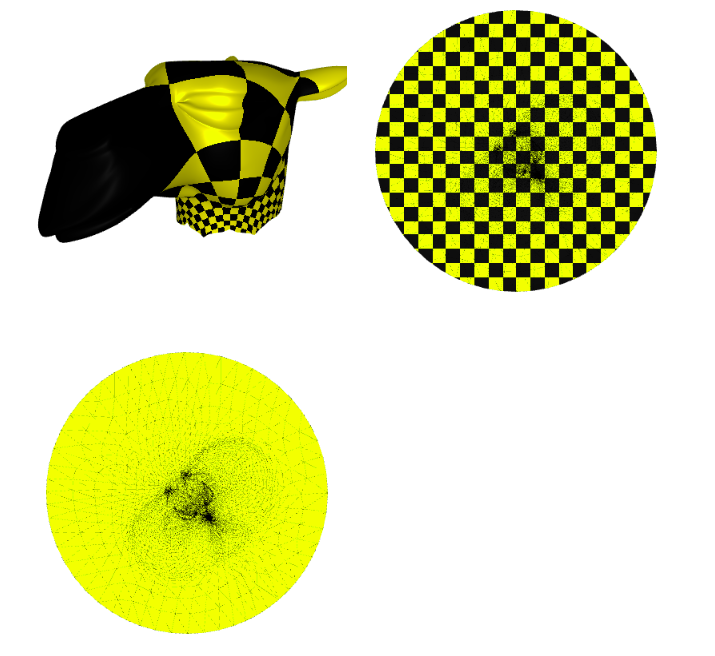

In [38]:
p = subplot(v_camel, f_camel, uv=uv, shading={"wireframe": False, "flat": False}, s=[1, 2, 0])
subplot(uv, f_camel, uv=uv, shading={"wireframe": True, "flat": False}, s=[1, 2, 1],data=p)
subplot(uv, f_camel, uv=uv, shading={"wireframe": True, "flat": False}, s=[1, 2, 1],texture_data=utils.gen_checkers(1,1,1,1))
Image(os.path.join(root_folder, "data", "mesh-6.png")) # This is what it supposed to look like

# 6.  <a id='references'></a>References

1. Alec Jacobson, Daniele Panozzo, & others. (2018). libigl: A simple C++ geometry processing library. https://libigl.github.io/
2. Sebastian Kock.(2019). MeshPlot. https://skoch9.github.io/meshplot/tutorial/
3. Mikhail Bessmeltsev. (2019). Geometric Modeling and Shape Analysis. http://www-labs.iro.umontreal.ca/~bmpix/teaching/6113/2019/
4. Solomon, Justin. Numerical algorithms: methods for computer vision, machine learning, and graphics. CRC press, 2015.
5. Solomon, Justin. 6.838: Shape Analysis (Spring 2019). https://groups.csail.mit.edu/gdpgroup/6838_spring_2019.html
6. Gabriel Peyré. (2012). Mesh Processing Course. https://www.slideshare.net/gpeyre/mesh-processing-course-introduction
7. Keenan Crane. (2021). CS 15-458/858: Discrete Differential Geometry. https://brickisland.net/DDGSpring2021/